# Proyek Klasifikasi Gambar: Wonders of World
- **Nama:** Muhammad Fawaid As'ad
- **Email:** muhammadfawaidasad@gmail.com
- **ID Dicoding:** fawaid27

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import shutil
import splitfolders
from collections import Counter
import kagglehub

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import random
import cv2

## Data Preparation

### Data Loading

In [3]:
# Download dataset dari KaggleHub
dataset_path = kagglehub.dataset_download("balabaskar/wonders-of-the-world-image-classification")
raw_data_dir = os.path.join(dataset_path, "wonders_dataset")

100%|██████████| 432M/432M [05:28<00:00, 1.38MB/s] 

Extracting files...


In [2]:
# Hitung kelas dengan gambar terbanyak
def count_top_classes(directory, top_n=4):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([
                file for file in os.listdir(class_path)
                if file.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
            class_counts[class_name] = count
    sorted_counts = Counter(class_counts).most_common(top_n)
    print(f"\n{top_n} kelas dengan jumlah gambar terbanyak:")
    for class_name, count in sorted_counts:
        print(f"{class_name}: {count} gambar")
    return [cls for cls, _ in sorted_counts]

top_classes = count_top_classes('Wonders of World')


4 kelas dengan jumlah gambar terbanyak:
roman_colosseum: 394 gambar
machu_pichu: 393 gambar
great_wall_of_china: 392 gambar
eiffel_tower: 391 gambar


In [3]:
# Salin 4 kelas teratas ke folder baru
filtered_dir = "wonders_dataset_filtered"
if os.path.exists(filtered_dir):
    shutil.rmtree(filtered_dir)
os.makedirs(filtered_dir)

for cls in top_classes:
    src = os.path.join('Wonders of World', cls)
    dst = os.path.join(filtered_dir, cls)
    shutil.copytree(src, dst)

### Data Preprocessing

#### Split Dataset

In [4]:
# Split ke train/val/test
splitfolders.ratio(filtered_dir, output="wonders_split", seed=42, ratio=(.7, .15, .15))

Copying files: 1570 files [00:01, 919.33 files/s]


In [5]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "wonders_split/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    "wonders_split/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    "wonders_split/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes


Found 1097 images belonging to 4 classes.
Found 233 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


## Modelling

In [6]:
# Load MobileNet tanpa top (tidak termasuk classifier-nya)
mobilenet_base = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [7]:
mobilenet_base.trainable = True
for layer in mobilenet_base.layers[:-20]:
    layer.trainable = False

In [8]:
# Buat model Sequential
model = Sequential([
    Input(shape=(224, 224, 3)),

    # Tambahkan base MobileNet
    mobilenet_base,

    # Tambah custom conv layers (optional)
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,910,404 (14.92 MB)

 Trainable params: 2,543,812 (9.70 MB)

 Non-trainable params: 1,366,592 (5.21 MB)

In [10]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model_mobilenet.keras", save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6849 - loss: 0.7753 - val_accuracy: 0.8841 - val_loss: 0.3368 - learning_rate: 1.0000e-04
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 989ms/step - accuracy: 0.9007 - loss: 0.2999 - val_accuracy: 0.9185 - val_loss: 0.1729 - learning_rate: 1.0000e-04
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9318 - loss: 0.2134 - val_accuracy: 0.9399 - val_loss: 0.1364 - learning_rate: 1.0000e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 964ms/step - accuracy: 0.9622 - loss: 0.1348 - val_accuracy: 0.9571 - val_loss: 0.1029 - learning_rate: 1.0000e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9637 - loss: 0.1169 - val_accuracy: 0.9700 - val_loss: 0.0752 - learning_rate: 1.0000e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 979ms/step - accuracy: 0.9683 - loss: 0.0963 - val_accuracy: 0.9742 - val_loss: 0.0749 - learning_rate: 1.0000e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 963ms/step - accuracy: 0.

## Evaluasi dan Visualisasi

In [11]:
# Evaluasi Train & Test
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"\n📊 Train Accuracy: {train_acc*100:.2f}%")
print(f"📊 Test Accuracy: {test_acc*100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 733ms/step - accuracy: 0.9909 - loss: 0.0288
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 672ms/step - accuracy: 0.9933 - loss: 0.0304

📊 Train Accuracy: 98.91%
📊 Test Accuracy: 99.17%


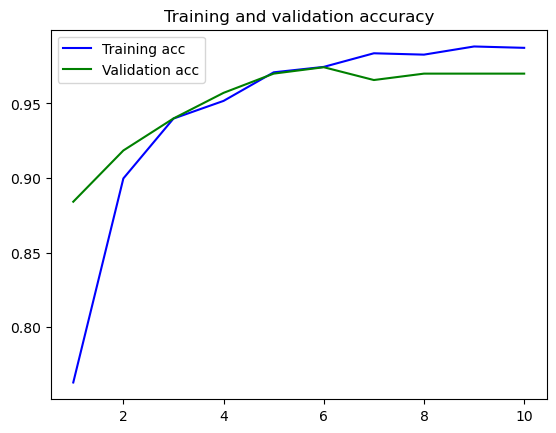

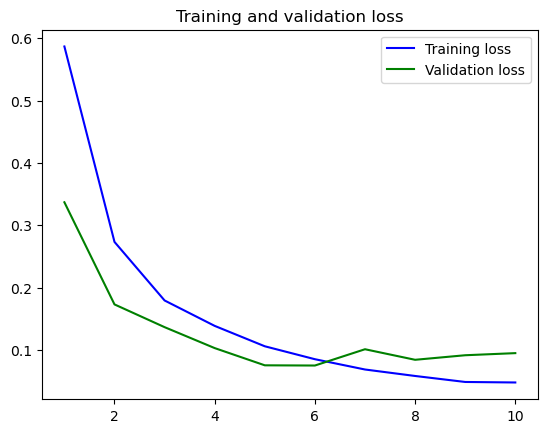

In [12]:
# Plot akurasi & loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_training_history(history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step


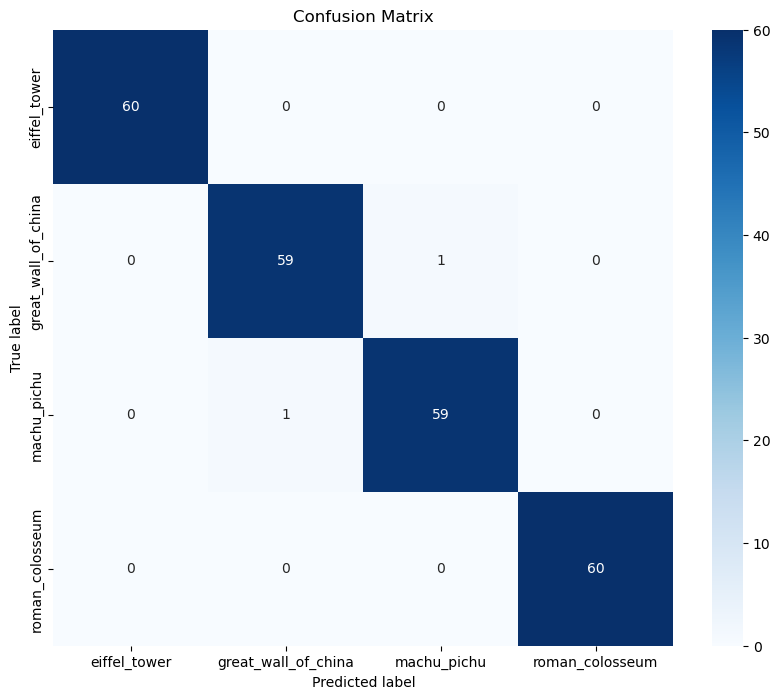


Classification Report:

                     precision    recall  f1-score   support

       eiffel_tower       1.00      1.00      1.00        60
great_wall_of_china       0.98      0.98      0.98        60
        machu_pichu       0.98      0.98      0.98        60
    roman_colosseum       1.00      1.00      1.00        60

           accuracy                           0.99       240
          macro avg       0.99      0.99      0.99       240
       weighted avg       0.99      0.99      0.99       240



In [13]:
# Confusion matrix
def plot_confusion_matrix(model, test_generator):
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(test_generator.classes, y_pred)
    class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(test_generator.classes, y_pred, target_names=class_names))

plot_confusion_matrix(model, test_generator)

Analisis
Berdasarkan hasil dari data tersebut dihasilkan :

🔹 Akurasi train vs test hampir sama tinggi (98.91% vs 99.17%)

🔹 Loss train vs test juga hampir sama (0.0288 vs 0.0304)

🔹 Classification report memperlihatkan skor f1, precision, dan recall yang konsisten di semua kelas

## Konversi Model

In [14]:
model.export('submission/saved_model')

INFO:tensorflow:Assets written to: submission/saved_model\assets


INFO:tensorflow:Assets written to: submission/saved_model\assets


Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_86')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2196111217232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111221264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111221648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111220880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111220112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111221456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111221072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111218768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111222224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111219920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2196111222608: TensorSpec

In [15]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()
os.makedirs("submission/tflite", exist_ok=True)
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)


In [16]:
# Save labels
class_names = list(train_generator.class_indices.keys())
with open("submission/tflite/label.txt", "w") as f:
    for item in class_names:
        f.write("%s\n" % item)

In [9]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model submission/saved_model submission/tfjs_model

Writing weight file submission/tfjs_model\model.json...


2025-05-08 23:13:37.565421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 23:13:38.682317: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-05-08 23:13:38.682459: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


In [22]:
# Simpan file requirements
with open("submission/requirements.txt", "w") as f:
    f.write("\n".join([
        "tensorflow",
        "split-folders",
        "tensorflowjs"
    ]))

## Inference (Optional)